In [1]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from torch.optim import Adam
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import lightgbm as lgb  
import warnings
warnings.filterwarnings("ignore")
from utils import r2_loss, train_model, plot_r2

# Data

In [2]:
subpath = "/home/onyxia/work/AML/data/"
weights = pl.read_parquet(subpath + "weights.parquet")
target = pl.read_parquet(subpath + "target.parquet")
responders = pl.read_parquet(subpath + "responders.parquet")
features = pl.read_parquet(subpath + "features.parquet")

# Architecture

## MLP Buider

In [3]:
def make_mlp(widths, activation=nn.ReLU):
    """
    widths : [in_dim, h1, h2, ..., out_dim]
    """
    layers = []
    for in_f, out_f in zip(widths[:-1], widths[1:]):
        layers.append(nn.Linear(in_f, out_f))
        layers.append(activation())
    layers.pop()  # retire la dernière activation inutile
    return nn.Sequential(*layers)


## Auto-Encoder supervised & unsupervised

In [4]:
class Encoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


class TaskHead(nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.net = make_mlp(widths)

    def forward(self, z):
        return self.net(z)


## Build up

In [5]:
class FullModel(nn.Module):
    def __init__(self,
                 encoder_widths,   # ex : [input_dim, 256, 128, latent_dim]
                 decoder_widths,   # ex : [latent_dim, 128, 256, input_dim]
                 head_widths       # ex : [latent_dim, 64, output_dim]
                ):
        super().__init__()

        self.encoder = Encoder(encoder_widths)
        self.decoder = Decoder(decoder_widths)
        self.head = TaskHead(head_widths)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        y_hat = self.head(z)
        return z, x_hat, y_hat


# Train real data

In [6]:
n = features.height
n_train = int(0.8 * n)

X_train = features.slice(0, n_train)
y_train = target.slice(0, n_train)

X_test = features.slice(n_train)
y_test = target.slice(n_train)


# --- 2. CONVERSION VERS NUMPY POUR LE CALCUL STATISTIQUE ---
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().reshape(-1, 1)


# --- 3. CALCUL DES STATISTIQUES SUR X_TRAIN ET Y_TRAIN ---

# Calcul de la moyenne (mean) et de l'écart-type (std) pour les features (X)
# Keepdims=True ensures the shape is retained for broadcasting
X_mean = np.mean(X_train_np, axis=0, keepdims=True)
X_std = np.std(X_train_np, axis=0, keepdims=True)

# Important: Avoid division by zero if a feature has zero standard deviation
# We replace 0 std with 1 to prevent division by zero, effectively skipping standardization for constant features.
X_std[X_std == 0] = 1 

# Calcul de la moyenne et de l'écart-type pour la cible (Y)
Y_mean = np.mean(y_train_np, axis=0, keepdims=True)
Y_std = np.std(y_train_np, axis=0, keepdims=True)
Y_std[Y_std == 0] = 1 


# --- 4. APPLICATION DE LA STANDARDISATION ---

# Application sur l'ensemble d'entraînement (X et Y)
X_train_scaled = (X_train_np - X_mean) / X_std
y_train_scaled = (y_train_np - Y_mean) / Y_std

# Application sur l'ensemble de test, en utilisant les stats de TRAIN! (X et Y)
X_test_scaled = (X_test_np - X_mean) / X_std
y_test_scaled = (y_test_np - Y_mean) / Y_std


# --- 5. CONVERSION VERS TENSEURS PYTORCH ---

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_scaled, dtype=torch.float32)

print("Standardization complete.")
print(f"X_train_t shape after scaling: {X_train_t.shape}")
print(f"Mean of X_train_t (should be ~0): {X_train_t.mean(dim=0)}")
print(f"Std of X_train_t (should be ~1): {X_train_t.std(dim=0)}")

Standardization complete.
X_train_t shape after scaling: torch.Size([1219662, 56])
Mean of X_train_t (should be ~0): tensor([ 8.1820e-09, -9.2579e-10,  3.9096e-09,  3.6093e-09,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.6298e-11, -8.7575e-09, -2.0017e-10,
         3.3816e-08,  1.4741e-07,  6.0051e-09, -1.4262e-09,  2.2563e-08,
        -2.6489e-07,  1.3570e-07,  1.3480e-08,  2.6043e-08, -1.0290e-07,
         2.5027e-07, -7.7481e-08,  1.3806e-08,  3.3966e-09,  9.9585e-09,
         4.3787e-10,  3.0463e-09,  1.1084e-08,  1.8516e-09, -1.4562e-08,
        -9.4174e-09, -1.8140e-09,  3.1277e-09,  1.8453e-09,  6.1552e-09,
         7.5564e-09, -2.5021e-11,  5.8800e-09, -2.0267e-09, -7.1874e-09,
        -1.4975e-08,  5.4396e-08,  1.0822e-09, -1.8134e-08,  1.2411e-08,
        -1.4913e-08, -5.8362e-09, -5.1044e-09, -5.8315e-09, -8.1945e-10,
        -7.4814e-09,  5.6235e-09,  6.8058e-08, -7.0085e-08,  2.7561e-08,
        -7.8442e-09])
Std of X_train_t (should be ~1): tensor([1.0000, 1.0000, 1

## MSE VS Huberloss

In [9]:
N_EPOCHS = 30
BATCH_SIZE = 512
LR = 1e-3
ENCODER_W = [X_train_t.shape[1], 64, 32, 32, 32, 16] # Example widths
DECODER_W = [16, 32, 32, 32, 64, X_train_t.shape[1]]
HEAD_W = [16, y_train_t.shape[1] if len(y_train_t.shape) > 1 else 1]


def run_loss_comparison(X_train_t, y_train_t, X_test_t, y_test_t):
    """
    Runs two separate training experiments to compare nn.MSELoss and nn.SmoothL1Loss.
    
    Args:
        X_train_t, y_train_t: Training tensors.
        X_test_t, y_test_t: Testing tensors.
    
    Returns:
        A dictionary containing the R^2 lists for both experiments.
    """
    results = {}
    
    # --- 1. Test avec nn.MSELoss (Référence) ---
    
    # Reinitialize model weights for a fair comparison
    model_mse = FullModel(
        encoder_widths=ENCODER_W,
        decoder_widths=DECODER_W,
        head_widths=HEAD_W
    )

    print("--- RUNNING TEST 1: NN.MSELoss ---")
    r2_rec_mse, r2_sup_mse, r2_lgbm_mse, losses_mse = train_model(
        model=model_mse,
        X_train_t=X_train_t, y_train_t=y_train_t,
        X_test_t=X_test_t, y_test_t=y_test_t,
        n_epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizer_cls=Adam,
        loss_rec_cls=nn.MSELoss,
        loss_sup_cls=nn.MSELoss
    )
    results['MSE'] = {'rec': r2_rec_mse, 'sup': r2_sup_mse, 'lgbm': r2_lgbm_mse}
    
    # --- 2. Test avec nn.SmoothL1Loss ---
    
    # Reinitialize model weights for a fair comparison
    model_smooth = FullModel(
        encoder_widths=ENCODER_W,
        decoder_widths=DECODER_W,
        head_widths=HEAD_W
    )

    print("\n--- RUNNING TEST 2: NN.SmoothL1Loss ---")
    r2_rec_smooth, r2_sup_smooth, r2_lgbm_smooth, losses_smooth = train_model(
        model=model_smooth,
        X_train_t=X_train_t, y_train_t=y_train_t,
        X_test_t=X_test_t, y_test_t=y_test_t,
        n_epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizer_cls=Adam,
        loss_rec_cls=nn.SmoothL1Loss,
        loss_sup_cls=nn.SmoothL1Loss
    )
    results['SmoothL1'] = {'rec': r2_rec_smooth, 'sup': r2_sup_smooth, 'lgbm': r2_lgbm_smooth}
    
    return results


def plot_comparison(results):
    """
    Plots the comparison of R² scores for three metrics (Rec, NN Sup, LGBM Sup) 
    between the MSE Loss and Smooth L1 Loss experiments.
    
    Args:
        results (dict): Dictionary containing the lists of R² scores for 'MSE' and 'SmoothL1' tests.
    """
    
    # Extraction des listes de résultats pour chaque métrique et chaque perte
    r2_rec_mse = results['MSE']['rec']
    r2_sup_mse = results['MSE']['sup']
    r2_lgbm_mse = results['MSE']['lgbm']
    
    r2_rec_smooth = results['SmoothL1']['rec']
    r2_sup_smooth = results['SmoothL1']['sup']
    r2_lgbm_smooth = results['SmoothL1']['lgbm']
    
    # Création de 3 sous-figures empilées verticalement
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    
    # Définition des étiquettes
    LABEL_MSE = 'MSE Loss Test'
    LABEL_SMOOTH = 'Smooth L1 Loss Test'
    
    # --- GRAPHIQUE 1 : R² de Reconstruction (Autoencodeur) ---
    axes[0].plot(r2_rec_mse, label=LABEL_MSE, linestyle='-', marker='o', color='tab:blue')
    axes[0].plot(r2_rec_smooth, label=LABEL_SMOOTH, linestyle='--', marker='x', color='tab:cyan')
    axes[0].set_title("1. R² Reconstruction (Autoencoder Loss)")
    axes[0].set_ylabel("R² Score")
    axes[0].grid(True)
    axes[0].legend(loc='lower right')

    # --- GRAPHIQUE 2 : R² Supervision NN (Task Head) ---
    axes[1].plot(r2_sup_mse, label=LABEL_MSE, linestyle='-', marker='o', color='tab:green')
    axes[1].plot(r2_sup_smooth, label=LABEL_SMOOTH, linestyle='--', marker='x', color='tab:orange')
    axes[1].set_title("2. R² Supervision NN (Task Head)")
    axes[1].set_ylabel("R² Score")
    axes[1].grid(True)
    axes[1].legend(loc='lower right')

    # --- GRAPHIQUE 3 : R² LGBM sur Z (Qualité de la Représentation) ---
    axes[2].plot(r2_lgbm_mse, label=LABEL_MSE, linestyle='-', marker='o', color='tab:red')
    axes[2].plot(r2_lgbm_smooth, label=LABEL_SMOOTH, linestyle='--', marker='x', color='tab:brown')
    axes[2].set_title("3. R² LGBM on Latent Features (Z)")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("R² Score")
    axes[2].grid(True)
    axes[2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

--- RUNNING TEST 1: NN.MSELoss ---
Epoch 01 | loss=3594.178 | R2_sup_NN=-0.0054 | R2_sup_LGBM=-0.0163 | R2_rec=-0.2429
Epoch 02 | loss=3197.493 | R2_sup_NN=0.0008 | R2_sup_LGBM=-0.0233 | R2_rec=-0.1748
Epoch 03 | loss=3069.043 | R2_sup_NN=0.0001 | R2_sup_LGBM=-0.0265 | R2_rec=0.0101
Epoch 04 | loss=2966.712 | R2_sup_NN=-0.0226 | R2_sup_LGBM=-0.0260 | R2_rec=0.1394
Epoch 05 | loss=2902.642 | R2_sup_NN=-0.0113 | R2_sup_LGBM=-0.1141 | R2_rec=0.1659
Epoch 06 | loss=2857.365 | R2_sup_NN=-0.0146 | R2_sup_LGBM=-0.0323 | R2_rec=0.2269
Epoch 07 | loss=2818.180 | R2_sup_NN=-0.0125 | R2_sup_LGBM=-0.0358 | R2_rec=0.1807
Epoch 08 | loss=2791.576 | R2_sup_NN=-0.0524 | R2_sup_LGBM=-0.0548 | R2_rec=0.2078
Epoch 09 | loss=2766.816 | R2_sup_NN=-0.0121 | R2_sup_LGBM=-0.0822 | R2_rec=0.2629
Epoch 10 | loss=2740.692 | R2_sup_NN=-0.0271 | R2_sup_LGBM=-0.0597 | R2_rec=-0.1103
Epoch 11 | loss=2728.092 | R2_sup_NN=-0.0374 | R2_sup_LGBM=-0.0882 | R2_rec=0.2768
Epoch 12 | loss=2697.185 | R2_sup_NN=-0.1412 | R2_s

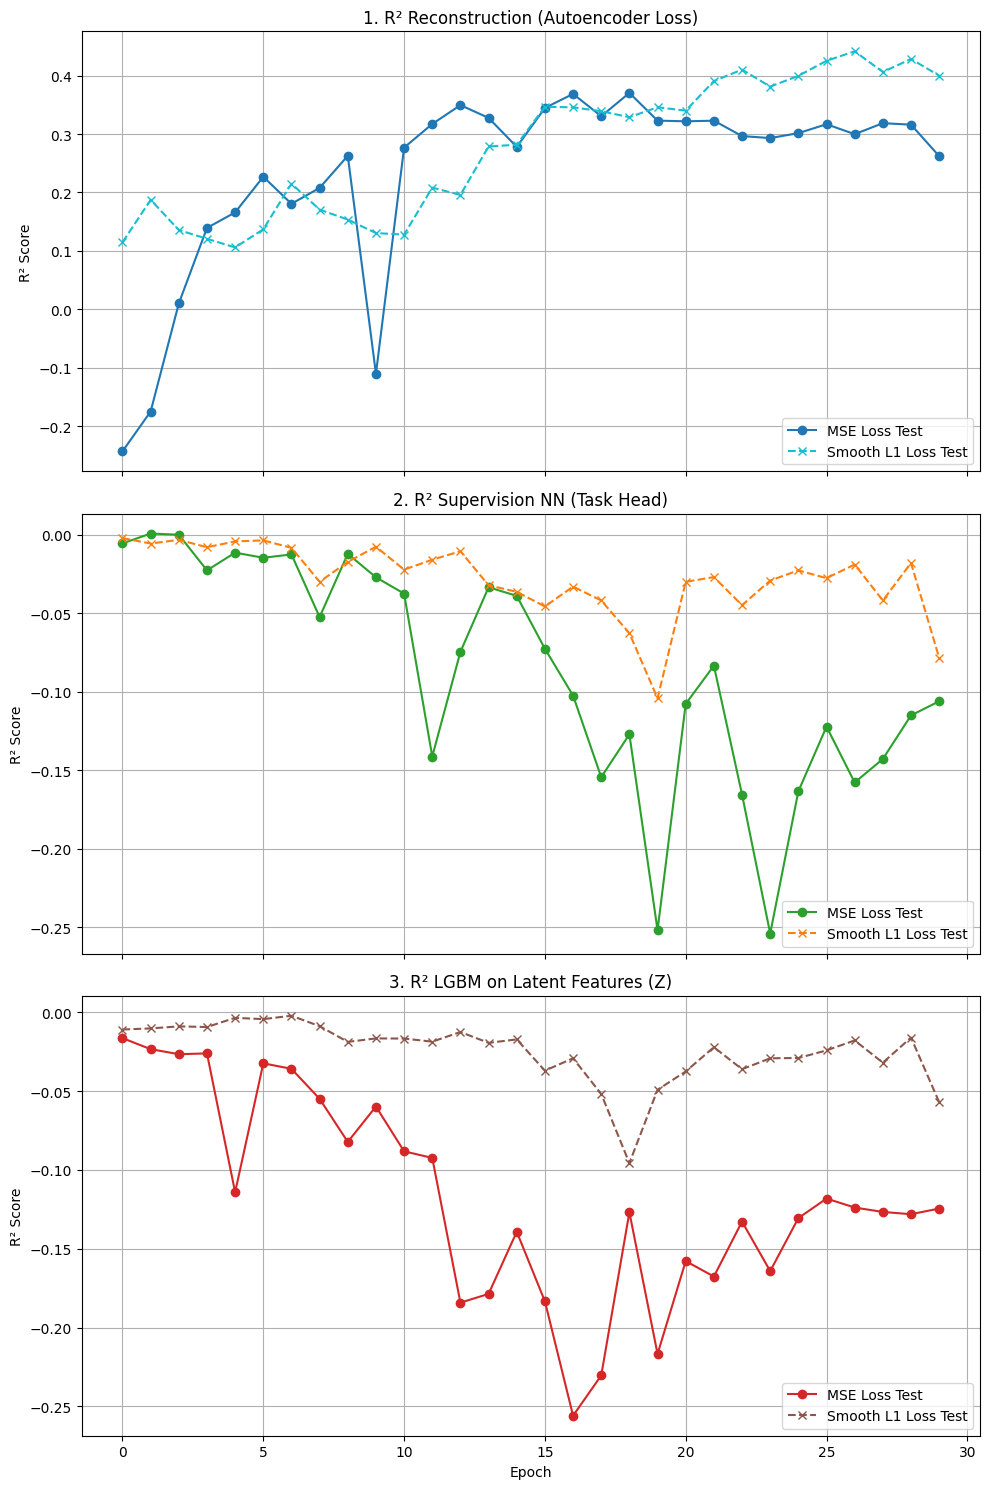

In [10]:
# Example usage (assuming X_train_t, etc. are defined and loaded):
results = run_loss_comparison(X_train_t, y_train_t, X_test_t, y_test_t)
plot_comparison(results)